# Fitting quasi-normal modes in GW190521

We demonstrate how to use `ringdown` to fit damped sinusoids in data from GW190521. We will fit a model composed of two long-lived (fundamental) modes, following [Siegel et al. (2023)](https://arxiv.org/abs/2307.11975). We will also use this as an example for loading open data directly from GWOSC using [GWpy](http://gwpy.github.io).

<div class="alert alert-info">

Note

The [GWpy package](http://gwpy.github.io/) is only an _optional_ dependence for `ringdown`: you should install it before running this notebook (e.g., `pip install gwpy`); alternatively, you can download the data separately and load it directly from disk as in the GW150914 example.

</div>

In [1]:
!pip install gwpy

We begin with some standard imports and global settings.

## Preliminaries

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Matplotlib is building the font cache; this may take a moment.


In [3]:
# disable numpy multithreading to avoid conflicts
# with jax multiprocessing in numpyro
import os
os.environ["OMP_NUM_THREADS"] = "1"
import numpy as np

# import jax and set it up to use double precision
from jax import config
config.update("jax_enable_x64", True)

# import numpyro and set it up to use 4 CPU devices
import numpyro
numpyro.set_host_device_count(4)
numpyro.set_platform('cpu')

# we will use matplotlib, arviz and seaborn for some of the plotting
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns

# disable some warning shown by importing LALSuite from a notebook
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

# import ringdown package
import ringdown as rd

# set plotting context
sns.set_context('notebook')
sns.set_palette('colorblind')

<div class="alert alert-info">

Tip

`ringdown` can run on GPUs! You can activate this through `numpyro.set_platform`. If running on a GPU, you will likely see significant performance improvements by using single precision, i.e., `config.update("jax_enable_x64", False)`; if doing so, `ringdown` will automatically attempt to scale quantities so that single precision is safe---but you should always check that this works for your data.

</div>

## Fitting Kerr modes

In this example, we will fit two prograde modes to the GW190521 data: $(\ell = 2, |m| = 2, n = 0)$ and $(\ell = 2, |m| = 1, n = 0)$.

The fit object expects to receive a list of modes to include in the fit; the most explicit way to specify them is to give tuples of `(p, s, l, m, n)`, where `p = +/- 1` indicates prograde/retrograde, `s = -2` is the spin weight, `l` and `m` are the usual angular quantum numbers, and `n` is the tone index.  The modes are elliptically polarized, so there is no need to specify both + and - `m` azimuthal numbers. (See [Isi & Farr (2021)](https://arxiv.org/abs/2107.05609).)

In [4]:
fit = rd.Fit(modes=[(1, -2, 2, 2, 0), (1, -2, 2, 1, 0), (1, -2, 3, 2, 0)])

We will also set an analysis time, target sky location and analysis duration. We will use some reference values corresponding to an estimate of the peak of GW150914:

In [5]:
fit.set_target(1242442967.4085817, ra=5.749613171792332, dec=-0.4237903906862163, psi=1.222853265910277, duration=0.4)

### Data preparation

In [6]:
fit.load_data(channel='gwosc', ifos=['H1', 'L1', 'V1'], seglen=8, sample_rate=16384, version=2)

As a sanity-check, we can plot of the raw strain we just loaded:

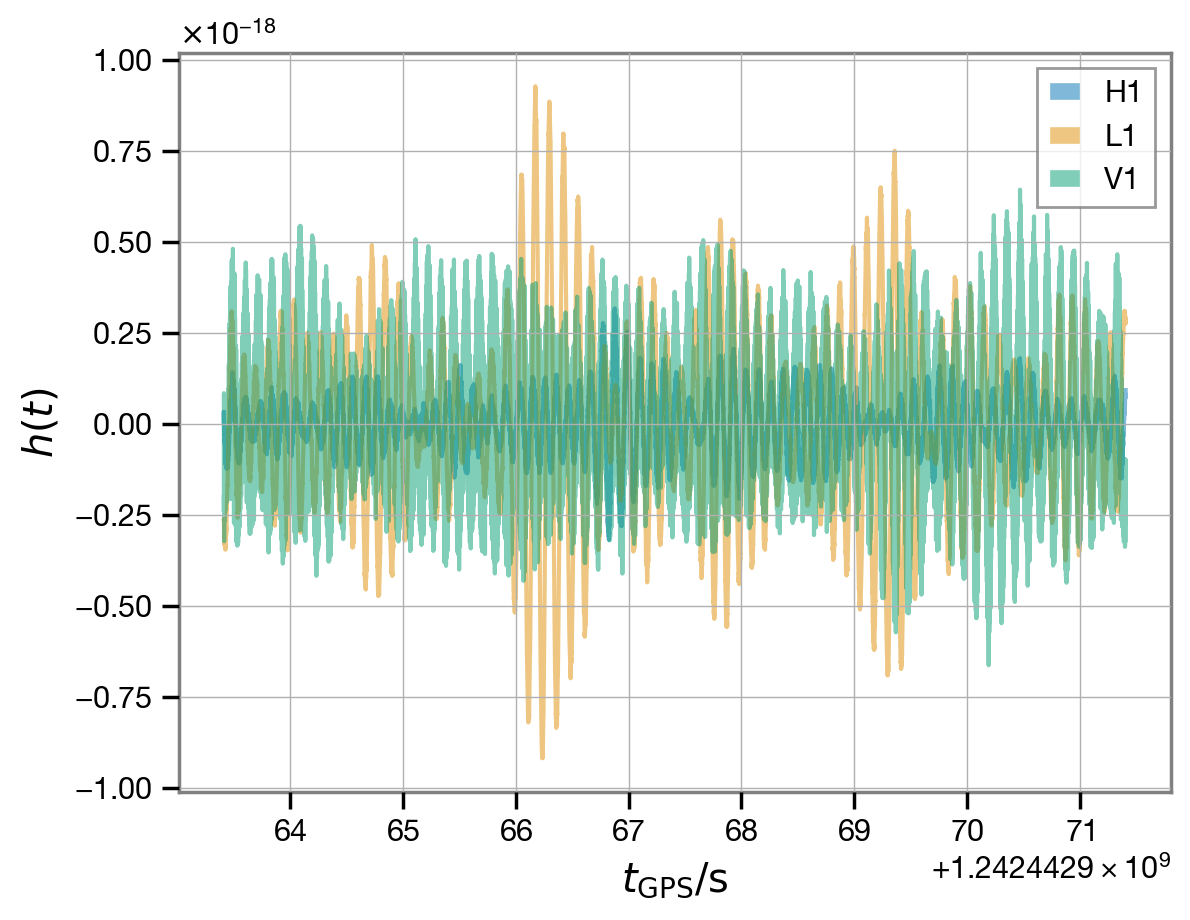

In [7]:
for ifo, data in fit.data.items():
    data[::8].plot(label=ifo, alpha=0.5)
plt.xlabel(r'$t_\mathrm{GPS} / \mathrm{s}$');
plt.ylabel(r'$h(t)$');
plt.legend(loc='best');

GWpy makes some default choices when fetching data from GWOSC.

In [8]:
fit.data['H1'].f_samp, fit.data['H1'].duration

(16384.0, 8.0)

In [9]:
!wget -nc https://dcc.ligo.org/public/0168/P2000158/004/GW190521_posterior_samples.h5

File ‘GW190521_posterior_samples.h5’ already there; not retrieving.



In [10]:
import h5py

f = h5py.File('GW190521_posterior_samples.h5', 'r')

In [11]:
psds = {}
for ifo in fit.ifos:
    f_p = f['NRSur7dq4']['psds'][ifo][()]
    p = rd.PowerSpectrum(f_p[:,1], index=f_p[:,0])
    p[p.freq < 8] = 100*p.loc[8]
    p[rd.utils.np2(p.freq[-1])] = p.iloc[-1]
    psds[ifo] = p.patch(f_min=8, f_max=512*0.86)

8.0 1024.0
8.0 1024.0
8.0 1024.0


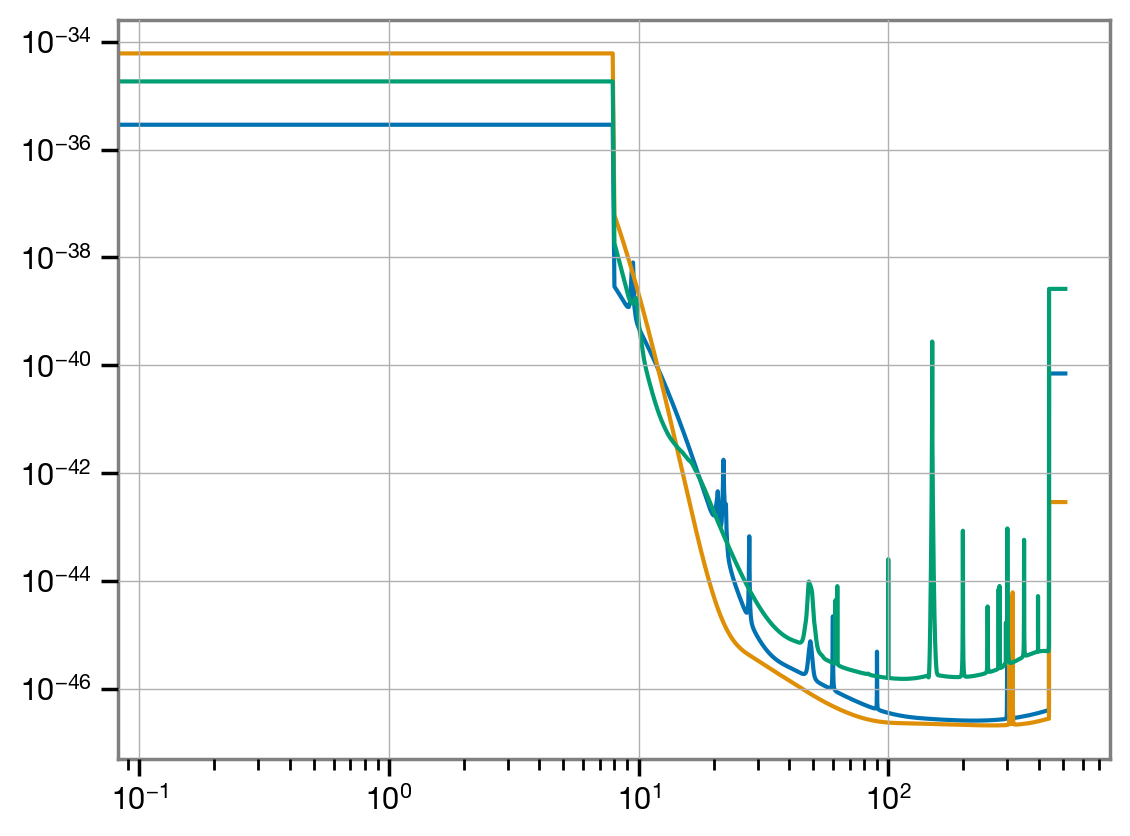

In [12]:
for i, p in psds.items():
    plt.loglog(p, label=i)
    print(p.duration, p.f_samp)

Now that the fit has data, it knows how to compute target times at indiviudal detectors:

In [13]:
fit.start_times

{'H1': 1242442967.427804, 'L1': 1242442967.425048, 'V1': 1242442967.4030466}

#### Data conditioning

Because the cost of our analysis scales as $N^2$ for a data segment of $N$ samples, and because the noise in LIGO combined with the finite bandwidth of ringdown modes means that the data are uninformative at both very low and very high frequencies, we can bandpass the data, downsample considerably (to eliminate high-frequency content), and truncate to a very short data segment (to eliminate low frequency content).  The `condition_data` method below accomplishes this.

When we downsample, we want to be sure to preserve a sample as close as possible to the requested target time at each detector. One issue we have to deal with is that the signal arrives in the detectors at different times (the time delay between detectors depends on the source location on the sky).  The `Fit` object knows how to handle this for us.

In [14]:
fit.condition_data(ds=16, f_min=8)

In [15]:
fit.acfs = {i: p.to_acf() for i, p in psds.items()}

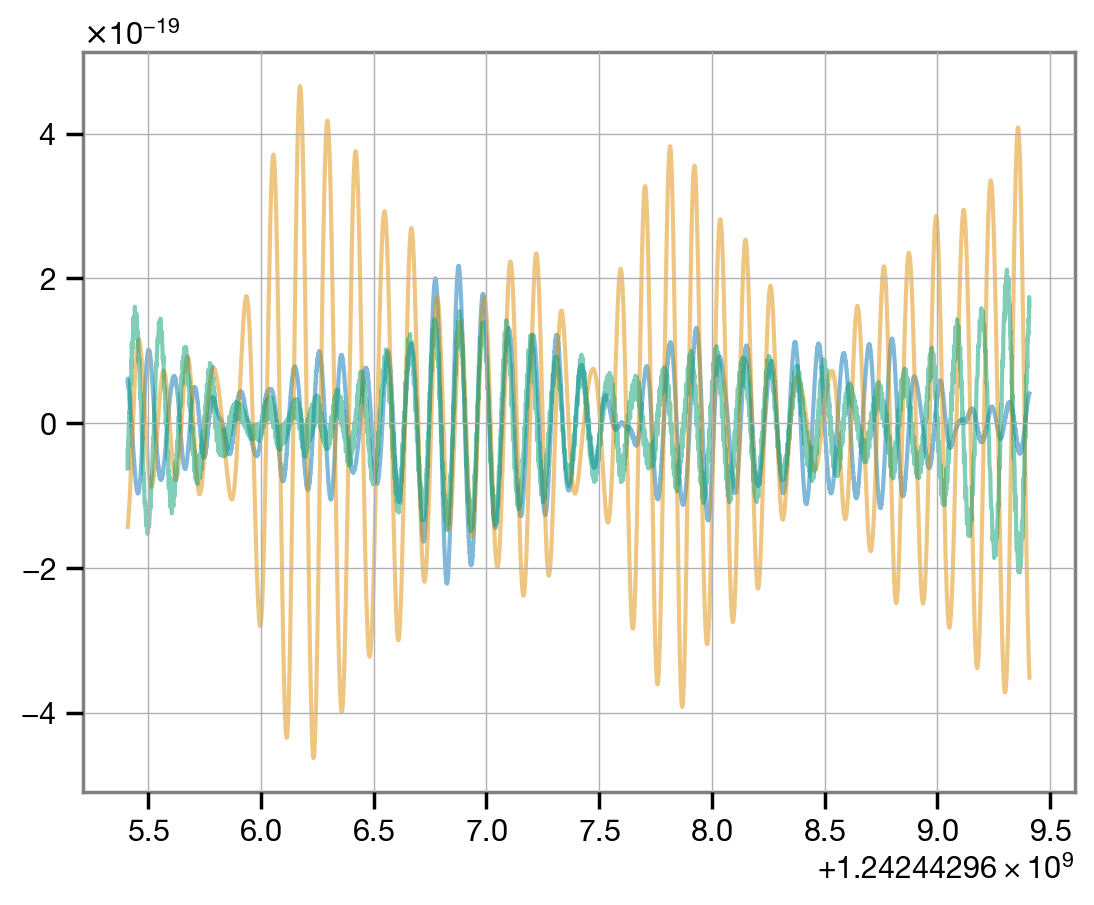

In [16]:
# plot data again
for ifo, data in fit.data.items():
    data.plot(label=ifo, alpha=0.5)

<div class="alert alert-info">

Warning

The conditioning function has a large number of options to manipulate the data in several ways. You should always make sure that the defaults make sense for your data!

</div>

We can visualize the segment of conditioned analysis data as another sanity check:

1024.0 4.0
1024.0 4.0
1024.0 4.0


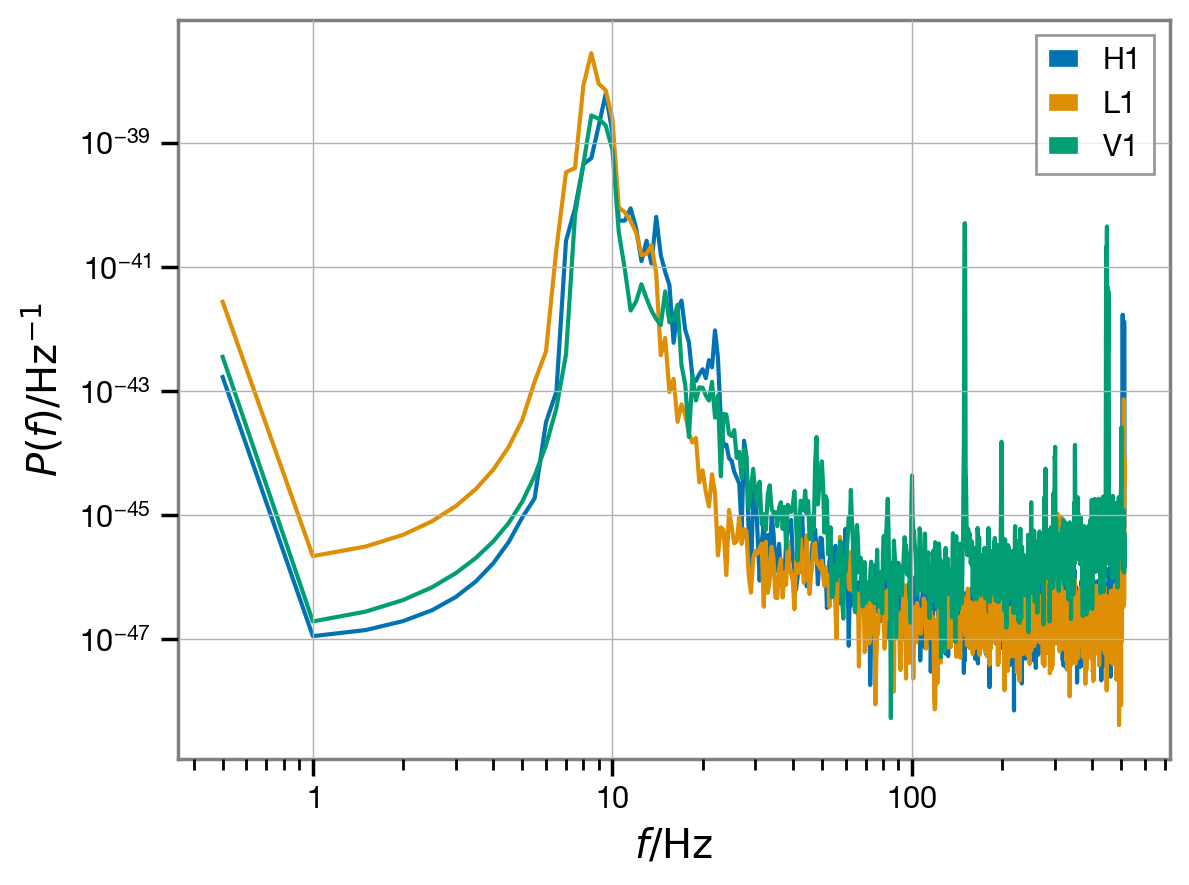

In [17]:
for ifo, data in fit.data.items():
    print(data.f_samp, data.duration)
    plt.loglog(data.get_psd(nperseg=rd.utils.np2(4*fit.n_analyze)).iloc[1:], label=ifo)
plt.xlabel(r'$f / \mathrm{Hz}$');
plt.ylabel(r'$P\left( f \right) / \mathrm{Hz}^{-1}$');
plt.legend(loc='best');

The wave arrived first at Livingston, then at Hanford, which is why the time segments are not exactly aligned.

#### Autocovariance function

A key ingredient in our likelihood calculation is the autocovariance function (ACF) of the noise, which is the time-domain equivalent of the power spectral density (PSD). You can load estimates of the ACF from disk, derive it from a PSD, or estimate it directly from the data. We do the latter below, with some default options.

In [18]:
# fit.compute_acfs(f_min=10, nperseg=rd.utils.np2(4*fit.n_analyze))

We can use the ACFs to whiten the analysis data and plot it once again.

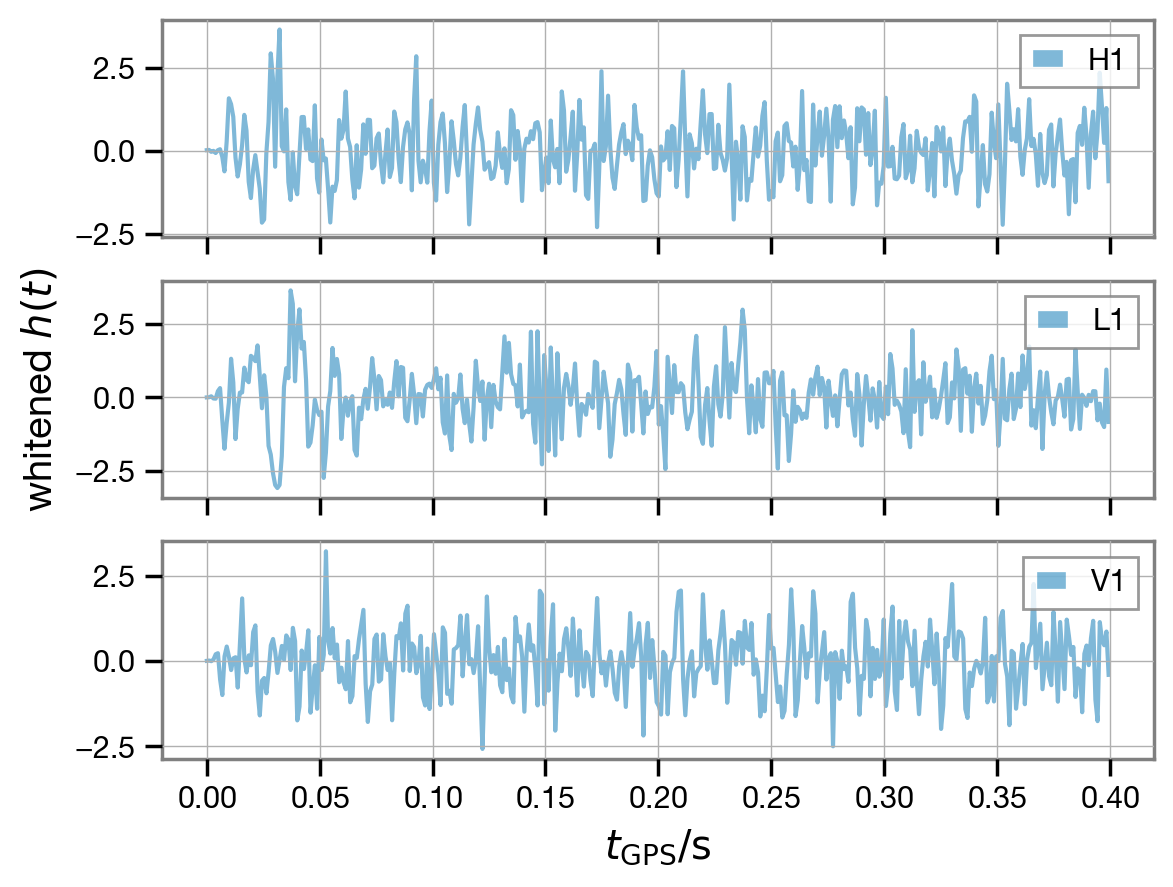

In [19]:
wd = fit.whiten(fit.analysis_data)
fig, axs = plt.subplots(len(fit.ifos), 1, sharex=True)
axs = np.atleast_1d(axs)
for (i, d), ax in zip(wd.items(), axs):
    t0 = fit.start_times[i]
    ax.plot(d.time - t0, d, label=i, alpha=0.5)
    ax.legend(loc='upper right');
axs[len(axs)//2].set_ylabel(r'whitened $h(t)$');
axs[-1].set_xlabel(r'$t_\mathrm{GPS} / \mathrm{s}$');

The signal is visible towards the beginning of the whitened data.

### Run fit

These settings determine the prior and type of fit. For a vanilla Kerr fit with generic mode polarizations (not parametrized in terms of a source inclination), we only need to specify an amplitude scale, and a mass range.

In [20]:
fit.update_model(a_scale_max=2e-20, m_min=128, m_max=512, chi_max=0.99, cosi=1)

In [21]:
rd.qnms.get_ftau(70, 0.7, n=0, l=3, m=2)

(350.440511991165, 0.004095329813033091)

We are finally ready to run! This should only take a couple of minutes on a modern desktop computer using CPUs.

In [22]:
from ringdown.utils import swsh
from jax import numpy as jnp
import jax

In [23]:
fit.set_modes([(1,-2,2,2,0)])
model = fit.run(num_chains=4, prior=True)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [24]:
fit.set_modes([(1,-2,2,2,0),(1,-2,2,1,0)])
model = fit.run(num_chains=4, prior=True)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [25]:
fit.set_modes([(1,-2,2,2,0),(1,-2,2,1,0),(1,-2,3,2,0)])
model = fit.run(num_chains=4, prior=True)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [26]:
from importlib import reload
reload(swsh)

<module 'ringdown.utils.swsh' from '/Users/maxisi/src/ringdown/ringdown/utils/swsh.py'>

In [27]:

mode_array = np.array([(1, -2, 2, 2, 0), (1, -2, 2, 1, 0), (1, -2, 3, 2, 0)])

ylm = jax.jit(swsh.construct_sYlm(-2, mode_array[:,2], mode_array[:,3]))

In [28]:
ylm(1)

Array([1.99566312, 0.0089249 , 2.3612296 ], dtype=float64)

In [29]:

mode_array = np.array([(1, -2, 2, 2, 0), (1, -2, 2, 2, 1)])
ylm2 = jax.jit(swsh.construct_sYlm(-2, mode_array[:,2], mode_array[:,3]))

In [30]:
ylm2(1)

Array([1.99566312, 1.99566312], dtype=float64)

In [32]:
# az.plot_pair(fit.result, var_names=['m', 'chi'], marginals=True,
#              kind='kde', reference_values={'m': 250, 'chi': 0.7});

We can visualize the result of the fit using a trace plot. This allows us to visualize the chains and diagnose any potential divergences.

In [34]:
# az.plot_trace(fit.result, var_names=['m', 'chi', 'a', 'f', 'g']);

We can access the posterior samples directly in `fit.result.posterior`. We can also obtain a Pandas `DataFrame` with all chains stacked together. This can be really convenient for plotting and other manipulations.

In [35]:
# draw 500 samples from the posterior
# fit.result.get_parameter_dataframe(500, latex=True)

### Plot results

We can make some quick plots of the results using arviz and seaborn. Below we demonstrate a few possible ways of doing this.

#### Remnant mass and spin

#### Mode amplitudes

#### Mode frequencies

#### Waveform reconstructions

Plot 90% credible interval for the reconstructions at each detector.

#### Signal to noise ratio